In [2]:
%pylab inline
# import igraph
import matplotlib.pyplot as plt
import sys, os
print(os.getcwd())
sys.path.append('../code')
from rnnmodel import *
from notebookutils import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
/its/home/cg610/inferring_inference_scripts/notebooks


In [3]:
import importlib
print(os.getcwd())
sys.path.append('../code')
import tapdynamics as tap

importlib.reload(tap)


/its/home/cg610/inferring_inference_scripts/notebooks


<module 'tapdynamics' from '/its/home/cg610/inferring_inference_scripts/notebooks/../code/tapdynamics.py'>

## 1. Generate parameters used to generate TAP dynamics

In [4]:
# set noise seed
noise_seed = 2022
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))

model_type = 1 # 1: Ux + b, 0: Ux

# Ns = no. of latent variables, Nr = no. of neurons, Ny = no. of inputs
Ns, Nr, Ny = 2, 100, 2

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
# Carter changed from signal.hamming to signal.windows.hamming 
smoothing_filter = signal.windows.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)


# ground truth TAP model parameters
# lam controls how much new messages update activation
# lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics
lam = np.array([1])  # low pass filtering constant for the TAP dynamics
# This should give us J*x_i*x_j
# The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
# the exponent of J, x_i, and x_j. I believe the order is 100, 101, 102, 110, 111... so the element at index 1 (101) means
# that a and c have exponent 1. In other words, message to Xi only depends on J*Xj
G   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # message passing parameters of the TAP equation

# No self-coupling and no sparsity (each neuron connects to the other)
self_coupling_on, sparsity_J, gain_J, Jtype  = 0, 0, 3, 'nonferr' # interaction matrix settings
J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on)
# Overwrite J to easily test this on analytic boltzman machine. Note that matrix becomes symmetric
J = array([[0,.2],[.2,0]])

if model_type:
    gain_U = 1
    U   = gain_U*np.random.randn(Nr,Ns) # embedding matrix
else:
    gain_U = 3
    U   = gain_U*np.random.rand(Nr,Ns) # embedding matrix

if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
# Let's disconnect states from observations
# V = array([[0,0],[0,0]])
# concatenate parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

noise_seed = 2022


## 2. Generate training and validation data

In [5]:
B_train, B_val = 25000, 500       # No. of batches; I changed from 25k to 2.5k for training batches. 
                                 # It's also kind of confusing because a single batch is Ns x T 
                                 # instead of multiple Ns x T
                                 # 
T = 30                           # No. of time steps 
T_clip  = 5                     # No. of time steps to clip
T_low, T_high = 2, 5             # range of time periods for which input is held constant
yG_low, yG_high = 2, 50          # range of input gains
yG_low, yG_high = 2, 5          # Changing this so the latent probs aren't as extreme

# For TAP_func, you can either pass in normal message passing function (runTAP) or Gibb's Sampling (runSamplingTAP)
TAP_func = runSamplingTAP
# TAP_func = runTAP
y_train, latent_probs, r_train = tap.generate_TAPdynamics(theta, params, B_train, T+T_clip, T_low, T_high, yG_low, yG_high,TAP_func=TAP_func)

y_val, latent_val_probs, r_val = tap.generate_TAPdynamics(theta, params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high,TAP_func=TAP_func)

In [6]:
# Add baseline to make neural activity positive

baseline = -np.min(r_train) if model_type else 0
r_train += baseline
r_val += baseline

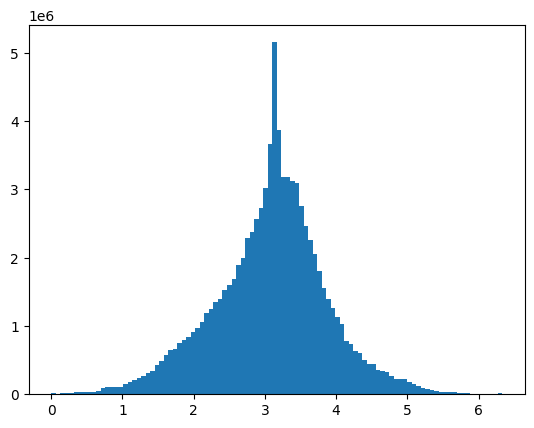

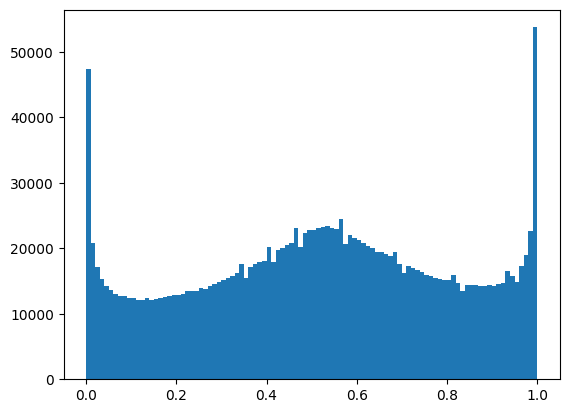

In [7]:
# Plot histogram of training data
plt.hist(r_train.flatten(),100)
plt.show()

plt.hist(latent_probs.flatten(),100)
plt.show()

temp = np.array(latent_probs)
print()

In [8]:
"""
Convert ground truth dynamics data to torch tensors
"""    

y_train = torch.tensor(y_train.transpose(0,2,1), dtype=torch.float32) # input signal
r_train = torch.tensor(r_train.transpose(0,2,1), dtype=torch.float32) # target neural activity

y_val = torch.tensor(y_val.transpose(0,2,1), dtype=torch.float32) # input signal
r_val = torch.tensor(r_val.transpose(0,2,1), dtype=torch.float32) # target neural activity


print('No. of batches x T x No. of neurons')
print('Training data:', r_train.shape, 'Validation data:', r_val.shape)

No. of batches x T x No. of neurons
Training data: torch.Size([25000, 35, 100]) Validation data: torch.Size([500, 35, 100])


In [ ]:
# Attempting to use dataloader!!!
# Not necessary to run

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        targets = self.targets[idx]
        return feature, targets

train_dataset = MyDataset(y_train, r_train)
val_dataset = MyDataset(y_val, r_val)

dataloader_train = DataLoader(
    train_dataset, 
    batch_size=16,
    num_workers=8,
    # drop_last=True,
    persistent_workers=True,  # Keep workers alive between iterations
    pin_memory=True,  # Set to False for CPU-only training
    prefetch_factor=2,  # Number of batches loaded in advance by each worker
    shuffle=True,
)

dataloader_val = DataLoader(
    val_dataset, 
    batch_size=16,
    num_workers=8,
    # drop_last=True,
    persistent_workers=True,  # Keep workers alive between iterations
    pin_memory=True,  # Set to False for CPU-only training
    prefetch_factor=2,  # Number of batches loaded in advance by each worker
    shuffle=True,
)

In [ ]:
# This code block is for debugging the dataloader pipeline
# Not necessary to run

import torch
import math
import traceback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Replace these with your actual objects
# model = ... 
# optimizer = ...
# loss_fn = torch.nn.MSELoss()  # or your loss

# Grab one batch
r_batch, y_batch = next(iter(dataloader_train))
print("Loaded batch shapes (cpu):", r_batch.shape, y_batch.shape)

def cuda_mem_info():
    if not torch.cuda.is_available():
        return "no cuda"
    return (
        f"allocated={torch.cuda.memory_allocated()/1024**2:.1f}MB, "
        f"reserved={torch.cuda.memory_reserved()/1024**2:.1f}MB, "
        f"max_alloc={torch.cuda.max_memory_allocated()/1024**2:.1f}MB"
    )

# Step 1: move to device (catch OOM)
try:
    r = r_batch.to(device, non_blocking=True)
    y = y_batch.to(device, non_blocking=True)
    print("Moved to device:", r.shape, y.shape, "|", cuda_mem_info())
except RuntimeError as e:
    print("Error during .to(device):", e)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    raise

# Step 2: forward pass
try:
    tapbrain.train()  # ensure training mode
    # small hook to check model output without full forward if you want
    out = tapbrain(r)           # <- may crash / OOM
    print("Forward OK, out shape:", getattr(out, "shape", type(out)), "|", cuda_mem_info())
    # check NaNs in output
    if torch.is_tensor(out) and torch.isnan(out).any():
        print("Warning: NaNs in model output")
except Exception as e:
    print("Exception during forward:")
    traceback.print_exc()
    raise

# Step 3: compute loss
try:
    loss = loss_fn(out, y)
    print("Loss computed:", loss.item() if isinstance(loss, torch.Tensor) else loss, "|", cuda_mem_info())
    if isinstance(loss, torch.Tensor) and (not math.isfinite(loss.item())):
        print("Warning: loss is not finite")
except Exception as e:
    print("Exception during loss computation:")
    traceback.print_exc()
    raise

# Step 4: backward
try:
    optimizer.zero_grad()
    loss.backward()
    # optionally inspect grad norms
    total_grad_norm = 0.0
    for p in tapbrain.parameters():
        if p.grad is not None:
            total_grad_norm += (p.grad.data.norm(2).item() ** 2)
    total_grad_norm = total_grad_norm ** 0.5
    print("Backward OK, grad norm:", total_grad_norm, "|", cuda_mem_info())
except RuntimeError as e:
    print("RuntimeError during backward (possible OOM):", e)
    if torch.cuda.is_available():
        print("Trying torch.cuda.empty_cache() and retrying zero_grad/backward is not safe — reduce batch size or model.")
        torch.cuda.empty_cache()
    raise
except Exception as e:
    print("Exception during backward:")
    traceback.print_exc()
    raise

# Step 5: optimizer step
try:
    optimizer.step()
    print("Optimizer step OK |", cuda_mem_info())
except Exception as e:
    print("Exception during optimizer.step():")
    traceback.print_exc()
    raise


Using device: cpu


## 3. Create RNN model

In [9]:
N_input, N_hidden, N_output = Ny, 1000, Nr

use_cuda = True

tapbrain = RNN(N_input, N_hidden, N_output, use_cuda)

loss_fn = nn.MSELoss()

if use_cuda and torch.cuda.is_available():
    tapbrain.cuda()
    
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

True


## 4. Training

In [10]:
NIters = 800000  # No. of iterations for training the RNN
batch_size = 16  # batch size for training the RNN. Number of Ns x T matrices.
epoch = B_train//batch_size # No. batches in an epoch

learningrate = 1e-5
optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate, betas=(0.9, 0.999))

train_loss, val_loss = [], []

In [12]:
t_st = time.time()
tapbrain = tapbrain.to(device)
y_train = y_train.to(device)
r_train = r_train.to(device)
y_val = y_val.to(device)
r_val = r_val.to(device)

tapbrain.train()

for iteration in range(NIters):
    
    if iteration == NIters//2:
        optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate/2, betas=(0.9, 0.999))
    
    optimizer.zero_grad()
    
    batch_index = torch.randint(0, B_train,(batch_size,))

    # Get the activation of the output layer neurons (i.e., [0])
    #rhat_train  = tapbrain(y_train[batch_index].cuda())[0]
    rhat_train  = tapbrain(y_train[batch_index])[0]
    # Train the RNN so that the output layer matches linear transformation of hidden state activation in graphical model
    # stored in r_train. Only train on the last 30 time points (from T_clip) of RNN activation.
    # mse_train = loss_fn(r_train[batch_index,T_clip:].cuda(), rhat_train[:,T_clip:])
    mse_train = loss_fn(r_train[batch_index,T_clip:], rhat_train[:,T_clip:])

    mse_train.backward()  
    
    optimizer.step()
    
    if (iteration + 1) % epoch == 0:
        with torch.no_grad():
            # carter changed to remove cuda
            # rhat_val = tapbrain(y_val.cuda())[0]
            # mse_val = loss_fn(r_val[:,T_clip:].cuda(), rhat_val[:,T_clip:])
            rhat_val = tapbrain(y_val)[0]
            mse_val = loss_fn(r_val[:,T_clip:], rhat_val[:,T_clip:])
            
        train_loss.append(mse_train.item())
        val_loss.append(mse_val.item())
        
    if (iteration + 1) % 5000 == 0:
        #print('[%d] training loss: %.5f' %(iteration + 1, mse_train.item()))
        print(f"[{iteration+1}] time elapsed = {(time.time() - t_st)/60:.1f} mins , log training loss = {np.log10(mse_train.item()):.2f} ")

print('Finished training')
t_en = time.time()

print(f"Time elapsed = {t_en - t_st:.1f}s")

AcceleratorError: CUDA error: unspecified launch failure
Search for `cudaErrorLaunchFailure' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
###### THIS CODE BLOCK DOESN'T WORK
# For some reason dataloader causes the thing to break

t_st = time.time()
tapbrain = tapbrain.to(device)

tapbrain.train()

for iteration in range(NIters):
    for r_train, y_train in dataloader_train:
        y_train = y_train.to(device)
        r_train = r_train.to(device)
    
        if iteration == NIters//2:
            optimizer = optim.Adam(tapbrain.parameters(), lr=learningrate/2, betas=(0.9, 0.999))
        
        optimizer.zero_grad()
        
        batch_index = torch.randint(0, B_train,(batch_size,))

        # Get the activation of the output layer neurons (i.e., [0])
        #rhat_train  = tapbrain(y_train[batch_index].cuda())[0]
        rhat_train  = tapbrain(y_train[batch_index])[0]
        # Train the RNN so that the output layer matches linear transformation of hidden state activation in graphical model
        # stored in r_train. Only train on the last 30 time points (from T_clip) of RNN activation.
        # mse_train = loss_fn(r_train[batch_index,T_clip:].cuda(), rhat_train[:,T_clip:])
        mse_train = loss_fn(r_train[batch_index,T_clip:], rhat_train[:,T_clip:])

        mse_train.backward()  
        
        optimizer.step()
        
        if (iteration + 1) % epoch == 0:
            with torch.no_grad():
                # carter changed to remove cuda
                # rhat_val = tapbrain(y_val.cuda())[0]
                # mse_val = loss_fn(r_val[:,T_clip:].cuda(), rhat_val[:,T_clip:])
                for r_val, y_val in dataloader_val:
                    y_val = y_val.to(device)
                    r_val = r_val.to(device)
                    rhat_val = tapbrain(y_val)[0]
                    mse_val = loss_fn(r_val[:,T_clip:], rhat_val[:,T_clip:])
                
            train_loss.append(mse_train.item())
            val_loss.append(mse_val.item())
            
        if (iteration + 1) % 5000 == 0:
            #print('[%d] training loss: %.5f' %(iteration + 1, mse_train.item()))
            print(f"[{iteration+1}] time elapsed = {(time.time() - t_st)/60:.1f} mins , log training loss = {np.log10(mse_train.item()):.2f} ")

print('Finished training')
t_en = time.time()

print(f"Time elapsed = {t_en - t_st:.1f}s")

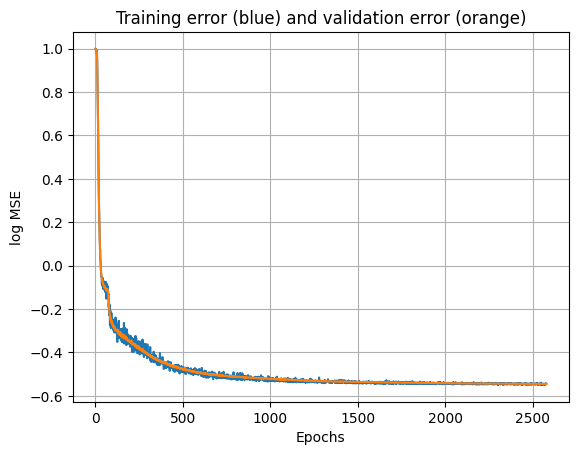

In [81]:
"""
Plot the training and validation MSE as a function of epochs
"""
plt.plot(np.log10(np.array(train_loss)))
plt.plot(np.log10(np.array(val_loss)))
plt.title('Training error (blue) and validation error (orange)')
plt.ylabel('log MSE')
plt.xlabel('Epochs')
plt.grid(True)
plt.show()

In [82]:
"""
Convert model to cpu and run the entire training and test data through the model
"""

tapbrain.cpu()
tapbrain.use_cuda = False

with torch.no_grad():
    rhat_val    = tapbrain(y_val)[0]


In [83]:
"""
Convert torch tensors to numpy
"""

del y_train, r_train

y_val    = y_val[:,T_clip:].data.numpy()
r_val    = r_val[:,T_clip:].data.numpy()
rhat_val = rhat_val[:,T_clip:].data.numpy()


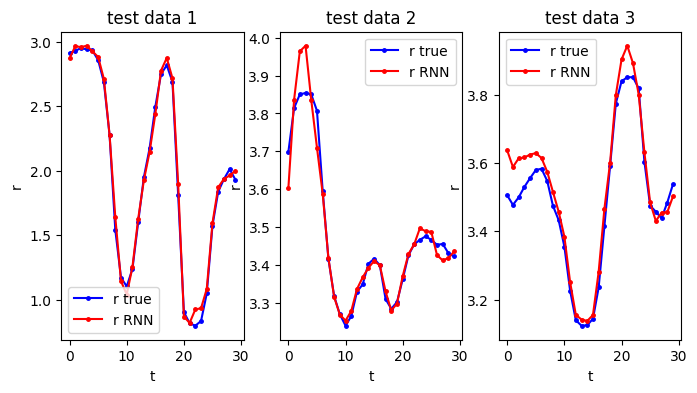

hi


In [84]:
"""
Plot fits to test data
"""
fig, ax = plt.subplots(1,3,figsize=(8,4))

ax[0].plot(r_val[5,:,1],'b.-',markersize=5)
ax[0].plot(rhat_val[5,:,1],'r.-',markersize=5)
ax[0].set(xlabel='t', ylabel='r', title ='test data 1')
ax[0].legend(['r true', 'r RNN'])

ax[1].plot(r_val[2,:,0],'b.-',markersize=5)
ax[1].plot(rhat_val[2,:,0],'r.-',markersize=5)
ax[1].set(xlabel='t', ylabel='r', title ='test data 2')
ax[1].legend(['r true', 'r RNN'])

ax[2].plot(r_val[0,:,0],'b.-',markersize=5)
ax[2].plot(rhat_val[0,:,0],'r.-',markersize=5)
ax[2].set(xlabel='t', ylabel='r', title ='test data 3')
ax[2].legend(['r true', 'r RNN'])

plt.show()
print("hi")

In [85]:
"""
Generate another test data set
"""

B_test = 5  # No. of batches
T_test = 1000 # No. of time steps 
TAP_func = runSamplingTAP
y_test, _, r_test = generate_TAPdynamics(theta, params, B_test, T_test+T_clip, T_low, T_high, yG_low, yG_high,TAP_func=TAP_func)

r_test = r_test.transpose(0,2,1) + baseline
y_test = torch.tensor(y_test.transpose(0,2,1), dtype=torch.float32) 

print('No. of batches x T x No. of neurons')
print('Test data:', r_test.shape)

No. of batches x T x No. of neurons
Test data: (5, 1005, 100)


In [86]:
"""
Run model on test data
"""
with torch.no_grad():
    rhat_test = tapbrain(y_test)[0]

y_test    = y_test[:,T_clip:].data.numpy()
r_test    = r_test[:,T_clip:]
rhat_test = rhat_test[:,T_clip:].data.numpy()

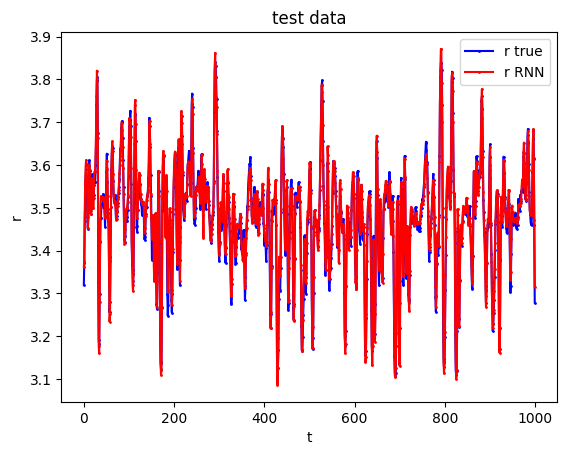

In [87]:
"""
Test data
"""
plt.plot(r_test[0,:,0],'b.-',markersize=2)
plt.plot(rhat_test[0,:,0],'r.-',markersize=2)
plt.xlabel('t')
plt.ylabel('r')
plt.title('test data')
plt.legend(['r true', 'r RNN'])
plt.show()

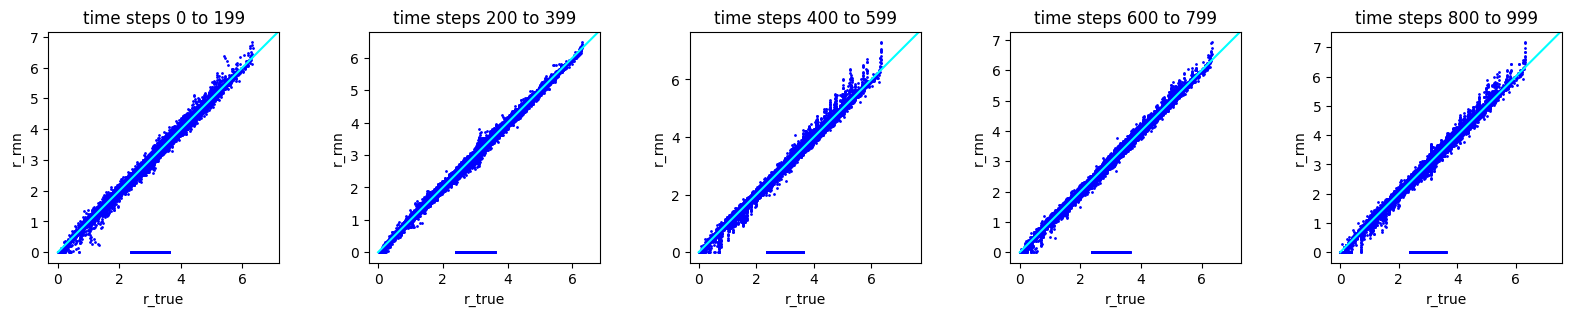

In [88]:
"""
Scatter plot for test data for every C time steps
"""
C = 200
N = T_test//C


fig, ax = plt.subplots(1,N,figsize=(4*N,3))
rmax = np.max(r_test)+2
for ni in range(N):
    ax[ni].plot(r_test[:,ni*C:(ni+1)*C].flatten(), rhat_test[:,ni*C:(ni+1)*C].flatten(),'b.',markersize=2)
    ax[ni].axis('square')
    ax[ni].plot([0,rmax],[0,rmax],color='cyan')
    ax[ni].set(xlabel='r_true', ylabel='r_rnn', title = 'time steps ' +str(ni*C)+ ' to ' + str(ni*C + C-1))

In [89]:
"""
Save trained brain and required variables
"""
if TAP_func == runSamplingTAP:
    algo_string = "sampling"
else:
    algo_string = "message_passing"


brain_name = '../data/brains/' + 'Ns_'+ str(Ns) + '_Nr_' + str(Nr) + '_noiseseed_' + str(noise_seed) + "_" + algo_string
torch.save(tapbrain,brain_name + '.pt')

params['baseline'] = baseline
with open(brain_name + '_params.pkl', 'wb') as f:  
    pickle.dump([theta, params], f)
f.close()

KeyboardInterrupt: 

In [11]:
brain_name

NameError: name 'brain_name' is not defined

## Plotting

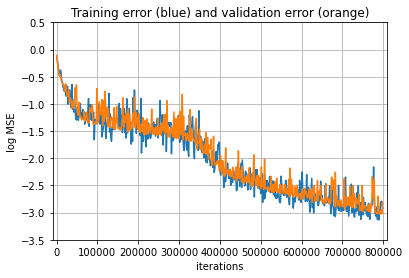

In [22]:
"""
Plot the training and validation MSE as a function of iterations
"""
iterations = np.arange(0,len(train_loss))*epoch
plot(iterations, np.log10(np.array(train_loss)))
plot(iterations, np.log10(np.array(val_loss)))
title('Training error (blue) and validation error (orange)')
ylabel('log MSE')
xlabel('iterations')
grid(True)
axis([-10000, 810000, -3.5, 0.5])
savefig("/home/rvraju/Desktop/Inferring_Inference/brain_2022_Nr_500/training.pdf")
show()

In [23]:
# requires igraph to be installed and imported
cmap = matplotlib.cm.get_cmap("coolwarm")
g = igraph.Graph.Adjacency((J !=0).tolist())
edge_weights = []
edge_colors = []
for (i,j) in g.get_edgelist():
    edge_weights.append(J[i,j])
    edge_colors.append(cmap(0.9*(J[i,j] > 0))[0:3])
edge_weights = np.abs(edge_weights)

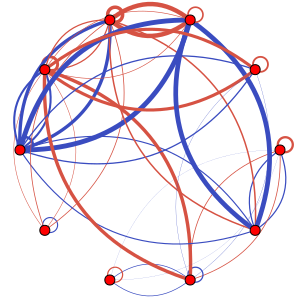

In [24]:
igraph.plot(g, "/home/rvraju/Desktop/Inferring_Inference/brain_2022_Nr_500/latent_graph.pdf",
            layout=g.layout("circle"), bbox=(300,300), margin=20, 
            vertex_size=10, 
            edge_arrow_size=0.01, 
            edge_width = 5*edge_weights, edge_color = edge_colors, 
           )

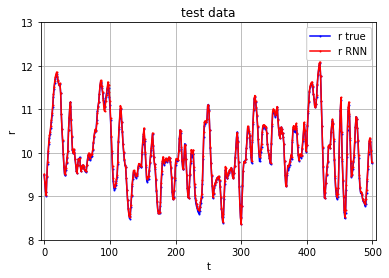

In [26]:
"""
Test data
"""
plot(r_test[0,0:500,300],'b.-',markersize=2)
plot(rhat_test[0,0:500,300],'r.-',markersize=2)
xlabel('t')
ylabel('r')
title('test data')
legend(['r true', 'r RNN'])
axis([-5,505,8,13])
grid(True)
savefig("/home/rvraju/Desktop/Inferring_Inference/brain_2022_Nr_500/example_neural_activity.pdf")
show()

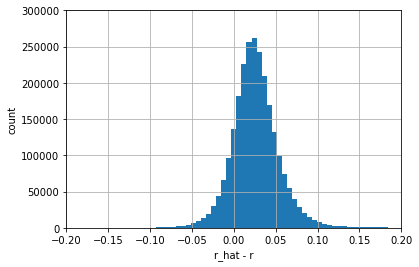

In [27]:
# Plot histogram of error
hist((rhat_test - r_test).flatten(),bins=np.linspace(-0.6,0.6,200))
axis([-0.2,0.2,0,300000])
grid(True)
xlabel('r_hat - r')
ylabel('count')
savefig("/home/rvraju/Desktop/Inferring_Inference/brain_2022_Nr_500/test_err_hist.pdf")
show()